## Car Escape

In [2]:
using TrajectoryOptimization
using Plots, LinearAlgebra, ForwardDiff, Interpolations

Import the car model

In [16]:
model = Dynamics.car
model_d = rk3(model) # discrete dynamics using RK3
n = model.n # number of states
m = model.m; # number of controls

Define numerical type

In [4]:
T = Float64;

Define initial and goal states

In [5]:
x0 = [2.5;2.5;0.]
xf = [7.5;2.5;0.];

Define cost functions, e.g., LQR

In [6]:
Qf = 100.0*Diagonal(I,n)
Q = (1e-3)*Diagonal(I,n)
R = (1e-2)*Diagonal(I,m)

2×2 Diagonal{Float64,Array{Float64,1}}:
 0.01   ⋅  
  ⋅    0.01

Define constraints

In [7]:
goal = goal_constraint(xf);

Construct trap constraint

In [8]:
r = 0.5
s1 = 30; s2 = 50; s3 = 15

circles_escape = []

for i in range(0,stop=5,length=s1)
    push!(circles_escape,(0.,i,r))
end
for i in range(0,stop=5,length=s1)
    push!(circles_escape,(5.,i,r))
end
for i in range(0,stop=5,length=s1)
    push!(circles_escape,(10.,i,r))
end
for i in range(0,stop=10,length=s2)
    push!(circles_escape,(i,0.,r))
end
for i in range(0,stop=3,length=s3)
    push!(circles_escape,(i,5.,r))
end
for i in range(5,stop=8,length=s3)
    push!(circles_escape,(i,5.,r))
end

n_circles_escape = 3*s1 + s2 + 2*s3

function cI_escape(c,x,u)
    for i = 1:n_circles_escape
        c[i] = circle_constraint(x,circles_escape[i][1],circles_escape[i][2],circles_escape[i][3])
    end
end

cI_wrap(c,z) = cI_escape(c,z[1:n],z[n .+ (1:m)])

ForwardDiff.jacobian(cI_wrap,zeros(n_circles_escape),rand(n+m))

function ∇cI_escape(C,x,u)
    copyto!(C,ForwardDiff.jacobian(cI_wrap,zeros(n_circles_escape),[x;u]))
end

trap = Constraint{Inequality}(cI_escape,∇cI_escape,n,m,n_circles_escape,:trap);

Set options

In [9]:
verbose=false

opts_ilqr = iLQRSolverOptions{T}(verbose=true,
    live_plotting=:off)

opts_al = AugmentedLagrangianSolverOptions{T}(verbose=true,
    opts_uncon=opts_ilqr,
    cost_tolerance=1.0e-4,
    cost_tolerance_intermediate=1.0e-2,
    constraint_tolerance=1.0e-3,
    penalty_scaling=50.,
    penalty_initial=10.)

opts_altro = ALTROSolverOptions{T}(verbose=true,
    opts_al=opts_al,
    R_inf=1.0e-3);

Define a problem

In [29]:
N = 101

tf = 3.0

U = [ones(m) for k = 1:N-1]

# create objective
obj = LQRObjective(Q,R,Qf,xf,N)

# create constraints
constraints = Constraints(N)
for k = 1:N-1
    constraints[k] += trap
end
constraints[N] += goal

# create problem
prob = Problem(model_d,obj,constraints=constraints,N=N,tf=tf,x0=x0,xf=xf)
initial_controls!(prob, U);

Infeasible state trajectory

In [30]:
X_guess = [2.5 2.5 0.;4. 5. .785;5. 6.25 0.;7.5 6.25 -.261;9 5. -1.57;7.5 2.5 0.]
X0 = interp_rows(N,tf,Array(X_guess'));

Initialize problem with state trajectory

In [31]:
copyto!(prob.X,X0);

Solve problem

In [32]:
solve!(prob, opts_altro); # solve with ALTRO

┌ Info: Infeasible Solve
└ @ TrajectoryOptimization /home/taylor/.julia/dev/TrajectoryOptimization/src/altro.jl:102
┌ Info: Augmented Lagrangian solve...
└ @ TrajectoryOptimization /home/taylor/.julia/dev/TrajectoryOptimization/src/altro.jl:24
iter  total  c_max       cost      info                                              
-------------------------------------------------------------------------------------
1     0       0.13978882  7.588057 
    iter cost          expected    z         α         ρ         dJ        grad      zero_count info                                              
____----------------------------------------------------------------------------------------------------------------------------------------------
    1     5.8282033536  1.76861257  0.995048  0.125     0e+00     1.759854  3.085551 0          
    2     4.2341895037  2.3791986   0.669979  0.25      0e+00     1.594014  2.633497 0          
    3     0.8047654735  3.77963473  0.907343  1         0e+0

Plot state trajectories

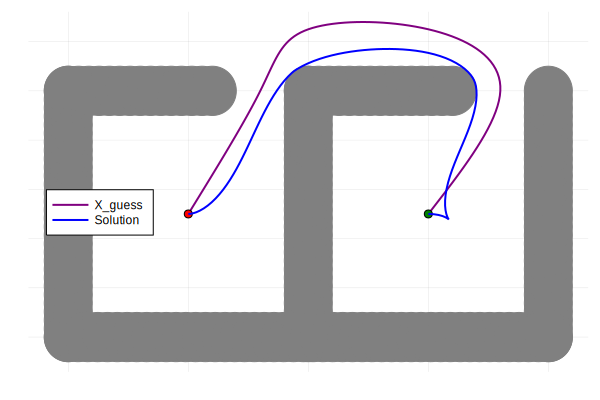

In [33]:
Problems.plot_escape(prob.X,prob.x0,prob.xf)